<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Чтение-данных" data-toc-modified-id="Чтение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Чтение данных</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренд" data-toc-modified-id="Тренд-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сезонность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><em>LinearRegression</em></a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><em>RandomForestRegressor</em></a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span><em>LGBMRegressor</em></a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span><em>CatBoostRegressor</em></a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Описание проекта:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Цели:**

Построить модель для предсказания количества заказов такси на следующий час.

Результаты исследования позволят привлечь больше водителей в период пиковой нагрузки.


**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


**Описание данных:**

Предоставлены исторические данные о заказах такси в аэропортах. Данные находятся в файле `taxi.csv`. Количество заказов (целевой признак) находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt # для построения распределений переменных
import numpy as np # для действий с данными
import pandas as pd # для загрузки данных
import seaborn as sns # для построения распределений переменных

from statsmodels.tsa.seasonal import seasonal_decompose # для разложения временного ряда на составляющие

from sklearn.pipeline import Pipeline # для автоматизации предварительных преобразований данных перед обучением модели
from sklearn.preprocessing import StandardScaler # для масштабирования численных признаков

from sklearn.metrics import mean_squared_error # для расчета RMSE модели
from sklearn.model_selection import cross_val_score # для использования кросс-валидации при обучении моделей
from sklearn.model_selection import GridSearchCV # для автоматического подбора параметров для моделей машинного обучения
from sklearn.model_selection import TimeSeriesSplit # для разделение на фолды в кросс-валидации
from sklearn.model_selection import train_test_split # для разбиения данных на обучающую и тестовую выборки

from catboost import CatBoostRegressor # для создания модели градиентного бустинга CatBoost для задачи регрессии
from lightgbm import LGBMRegressor # для создания модели градиентного бустинга LightGBM для задачи регрессии
from sklearn.ensemble import RandomForestRegressor # для создания модели случайного леса для задачи регрессии
from sklearn.linear_model import LinearRegression # для создания модели линейной регрессии

RANDOM_STATE = 12345 # для контроля случайности объектов

### Чтение данных

Загрузим данные. Установим индекс таблицы *data* равным столбцу *datetime* и изменим тип данных *datetime* с *object* на *datetime64*.

In [2]:
data = pd.read_csv(r'C:/Users/lorad/OneDrive/Documents/Моя папка/Data Science/Мои проекты/GitHubRepositories/'
                 'YandexPracticum/10_time_series_forecasting_taxi_orders/taxi.csv', index_col=[0], parse_dates=[0])
data.shape

(26496, 1)

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индекс таблицы и проверим, в хронологическом ли порядке расположены даты и время с помощью атрибута индекса таблицы *is_monotonic*.

In [5]:
data.sort_index(inplace=True)
print(data.index.is_monotonic)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование

Выполним ресемплирование данных по одному часу и вызовем функцию *sum()* для агрегации значений.

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Создание признаков

Напишем функцию для создания признаков: календарные признаки (день недели и час), отстающие значения (*lag*), скользящее среднее (*rolling*).

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    
    result = data.copy()
    
    result['dayofweek'] = data.index.dayofweek
    result['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        result['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    result['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return result

Применим функцию к таблице *data* с размером отставания (*lag*), равным 2, и с размером окна скользящего среднего (*rolling*), равным 24. Получим новый датасет.

In [8]:
data_plus = make_features(data, 2, 24)
data_plus

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667


**Вывод**. 

В этом разделе были выполнены следующие задачи:
1. данные прочитаны, в качестве индекса мы установили столбец *datetime* и изменили тип данных *datetime* с *object* на *datetime64*;
2. выполнено ресемплирование данных по одному часу;
3. созданы новые признаки: календарные признаки (день недели и час), отстающие значения, скользящее среднее.

Таким образом, данные подготовлены для дальнейшей работы.

## Анализ

Проанализируем временной ряд. У нас есть данные за полгода - с 1 марта по 31 августа 2018 года. Посмотрим тренд за этот период, а также сезонные изменения в пределах недели и дня.

### Тренд

Чтобы не мешала периодичность более высокого порядка, ресемплируем данные по дням.

In [9]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())

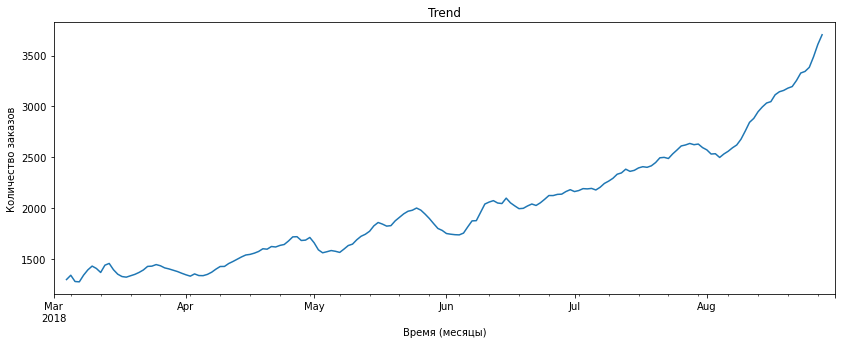

In [10]:
plt.figure(figsize=(14, 5))
decomposed_day.trend.plot(title='Trend')
plt.xlabel("Время (месяцы)")
plt.ylabel('Количество заказов')
plt.show()

На графике хорошо прослеживается рост числа заказов такси в аэропорт за полгода.

### Сезонность

Посмотрим, как изменяется число заказов такси в течение **недели**.

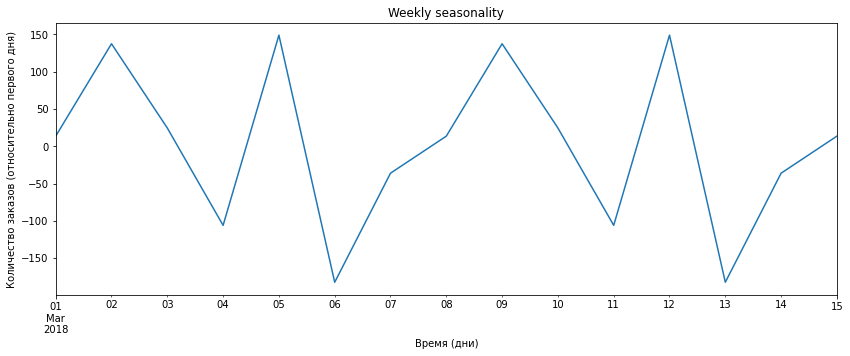

In [11]:
plt.figure(figsize=(14, 5))
decomposed_day.seasonal['2018-03-01':'2018-03-15'].plot(title='Weekly seasonality')
plt.xlabel("Время (дни)")
plt.ylabel('Количество заказов (относительно первого дня)')
plt.show()

Здесь видны пики во вторник и пятницу. То есть больше всего заказов такси в аэропорт приходится на начало и конец рабочей недели.

Посмотрим, как изменяется число заказов такси в течение **дня**. Для этого воспользуемся ресемплингом по часам.

In [12]:
decomposed_hour = seasonal_decompose(data)

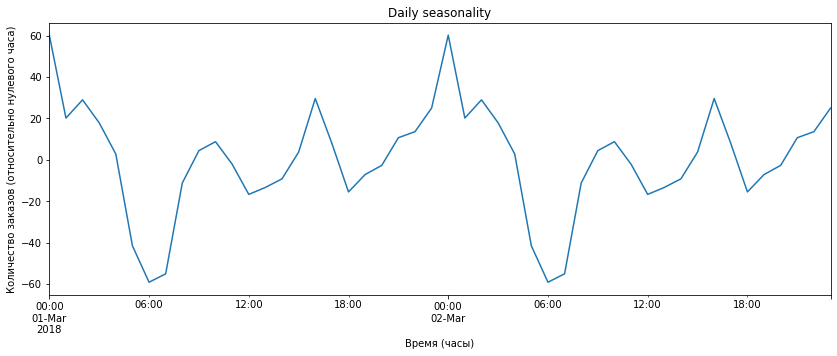

In [13]:
plt.figure(figsize=(14, 5))
decomposed_hour.seasonal['2018-03-01':'2018-03-2'].plot(title='Daily seasonality')
plt.xlabel("Время (часы)")
plt.ylabel('Количество заказов (относительно нулевого часа)')
plt.show()

Судя по графику, самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в ~10:00, в ~16:00 и самое загруженное время - в ~00:00.

**Вывод**. 

В этом разделе были выполнены следующие задачи:
1. проанализирован тренд за полугодовой период с 1 марта по 31 августа 2018 года;
2. проанализированы сезонные изменения в пределах недели и дня.

В результате выполнения задач этого раздела было выявлено следующее:
1. в течение всего полугодового периода с 1 марта по 31 августа 2018 года прослеживается рост числа заказов такси в аэропорт;
2. в пределах недели: больше всего заказов такси в аэропорт приходится на вторник и пятницу;
3. в пределах дня: самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в ~10:00, в ~16:00 и самое загруженное время - в ~00:00.

## Обучение

Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.

Разделим данные на обучающую и тестовую выборки в соотношении 9:1.

Перемешивать выборки в задаче прогнозирования временного ряда нельзя, поэтому укажем аргумент *shuffle* (с англ. «перетасовывать») равным *False*, чтобы разделить данные корректно. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего.

In [14]:
data_plus.dropna(inplace=True)

X = data_plus.drop('num_orders', axis=1)
y = data_plus['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [15]:
print('Размеры выборок:')
print(f'train: {len(X_train)} - {len(X_train)/len(data):.0%}')
print(f'test: {len(X_test)} - {len(X_test)/len(data):.0%}')

Размеры выборок:
train: 3952 - 89%
test: 440 - 10%


Обучим четыре модели: линейную регрессию (*Linear Regression*), случайный лес (*Random Forest*), градиентные бустинги *LightGBM* и *CatBoost*. Для последних трёх моделей применим поиск гиперпараметров с помощью *GridSearchCV*. Качество моделей оценим кросс-валидацией с метрикой *RMSE* и разделением на фолды *TimeSeriesSplit*.

Напишем функцию, которая подбирает лучшую модель с помощью *GridSearchCV*, выводит метрику *RMSE* и параметры лучшей модели. Используем разделение на фолды с помощью *TimeSeriesSplit*.

In [16]:
tscv = TimeSeriesSplit(n_splits=4) # n_splits - количество фолдов

In [17]:
def fit_model(estimator, param_grid, X_train, y_train):
    model = GridSearchCV(estimator=estimator,
                         param_grid=param_grid,
                         n_jobs=-1,
                         cv=tscv,
                         scoring='neg_root_mean_squared_error',
                        )

    model.fit(X_train, y_train)

    best_index = model.best_index_
    best_rmse = round(model.cv_results_['mean_test_score'][best_index], 1)

    print(f'Best RMSE: {abs(best_rmse)}')
    print(f'Best params: {model.best_params_}')

    return model.best_estimator_, model.best_score_

### *LinearRegression*

*LinearRegression* - линейная регрессия *Linear Regression*. 

Используем *Pipeline* для автоматизации предварительных преобразований данных перед обучением модели.

In [18]:
%%time

lr_estimator = Pipeline([
    ('lr', LinearRegression())
])

scores = cross_val_score(lr_estimator, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv)

rmse_lr = scores.mean()
print(f'RMSE: {abs(rmse_lr):.1f}')

RMSE: 32.1
CPU times: total: 46.9 ms
Wall time: 39.9 ms


Модель линейной регрессии ***Linear Regression*** имеет метрику оценки качества ***RMSE = 32.1***.

### *RandomForestRegressor*

*RandomForestRegressor* - случайный лес *Random Forest* для задачи регрессии.

In [19]:
%%time

rf_param_grid = {
    'max_depth': list(range(5, 12, 2)), # максимальная глубина дерева
    'n_estimators': list(range(50, 121, 10)), # количество деревьев
}

rf_best_model = fit_model(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    X_train=X_train,
    y_train=y_train
)

Best RMSE: 26.4
Best params: {'max_depth': 11, 'n_estimators': 120}
CPU times: total: 1.55 s
Wall time: 10.8 s


Наилучшая модель случайного леса ***Random Forest*** имеет метрику оценки качества ***RMSE = 26.4*** при следующих параметрах:
- максимальная глубина дерева: *max_depth = 11*;
- количество деревьев: *n_estimators = 120*.

### *LGBMRegressor*

*LGBMRegressor* - градиентный бустинг *LightGBM* для задачи регрессии.

In [20]:
%%time

lgbm_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1], # коэффициент скорости обучения (размер шага градиентного спуска)
    'max_depth': range(4, 9, 2), # максимальная глубина дерева
    'n_estimators': range(100, 201, 50), # количество деревьев (итераций)
}

lgbm_best_model = fit_model(
    estimator=LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=lgbm_param_grid,
    X_train=X_train,
    y_train=y_train
)

Best RMSE: 26.0
Best params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
CPU times: total: 719 ms
Wall time: 2.83 s


Наилучшая модель градиентного бустинга ***LightGBM*** имеет метрику оценки качества ***RMSE = 26.0*** при следующих параметрах:
- коэффициент скорости обучения (размер шага градиентного спуска): *learning_rate = 0.05*;
- глубина дерева: *max_depth = 8*;
- количество деревьев (итераций): *n_estimators = 100*.

### *CatBoostRegressor*

*CatBoostRegressor* - градиентный бустинг *CatBoost* для задачи регрессии.

*CatBoost* создает временные файлы для обучения. Чтобы не появлялась ошибка о том, что по указанными путям у *CatBoost* нет доступа к созданию файлов, укажем в модели параметр *allow_writing_files=False*.

Выведем также значения метрики *RMSE* различных моделей в виде таблицы.

In [21]:
%%time

catboost_param_grid = {
    'depth': range(2, 12, 3), # глубина дерева
    'iterations': range(250, 301, 50), # количество итераций
    'learning_rate': [0.05, 0.1, 0.15], # коэффициент скорости обучения (размер шага градиентного спуска)
}

catboost_best_model = fit_model(
    estimator=CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, allow_writing_files=False),
    param_grid=catboost_param_grid,
    X_train=X_train,
    y_train=y_train
)


table = pd.DataFrame(
    [['Linear Regression', f'{abs(rmse_lr):.1f}'],
     ['Random Forest', f'{abs(rf_best_model[1]):.1f}'],
     ['LightGBM', f'{abs(lgbm_best_model[1]):.1f}'],
     ['CatBoost', f'{abs(catboost_best_model[1]):.1f}']],
columns=['model', 'RMSE'])

table

Best RMSE: 26.3
Best params: {'depth': 5, 'iterations': 300, 'learning_rate': 0.05}
CPU times: total: 2.08 s
Wall time: 59 s


,model,RMSE
0,Linear Regression,32.1
1,Random Forest,26.4
2,LightGBM,26.0
3,CatBoost,26.3


Наилучшая модель градиентного бустинга ***CatBoost*** имеет метрику оценки качества ***RMSE = 26.3*** при следующих параметрах:
- глубина дерева: *depth = 5*;
- количество итераций: *iterations = 300*;
- коэффициент скорости обучения (размер шага градиентного спуска): *learning_rate = 0.05*.

В качестве лучшей модели выберем ***LightGBM***, так как метрика ***RMSE*** у нее мешьше остальных.

**Вывод**. 

В этом разделе были выполнены следующие задачи:
1. обучены четыре модели (*Linear Regression*, *Random Forest*, *LightGBM* и *CatBoost*) с различными гиперпараметрами;
2. в качестве лучшей модели выбрана ***LightGBM***, так как метрика ***RMSE*** у нее мешьше остальных.

В результате выполнения задач этого раздела было выявлено следующее:
- наилучшая модель градиентного бустинга ***LightGBM*** на обучающей выборке имеет метрику оценки качества ***RMSE = 26.0***.

## Тестирование

Проверим качесто выбранной модели ***LightGBM*** на тестовой выборке.

In [22]:
pred = lgbm_best_model[0].predict(X_test)

rmse = mean_squared_error(y_test, pred, squared=False) # параметр squared=False возвращает метрику RMSE
print(f'RMSE на тестовой выборке: {rmse:.1f}')

RMSE на тестовой выборке: 44.8


Наилучшая модель градиентного бустинга ***LightGBM*** на тестовой выборке имеет метрику оценки качества ***RMSE = 44.8***.

Для тестовой выборки построим график зависимости истинных и предсказанных значений количества заказов от времени.

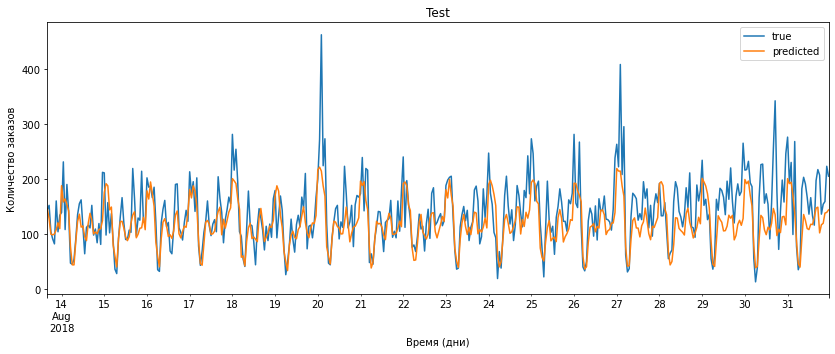

In [23]:
pred = pd.Series(pred, index=y_test.index)

plt.figure(figsize=(14, 5))
y_test.plot(label='true', title='Test')
pred.plot(label='predicted')
plt.legend()
plt.xlabel("Время (дни)")
plt.ylabel('Количество заказов')
plt.show()

На графике видно, что зависимости истинных и предсказанных значений количества заказов от времени имеют схожий характер.

**Вывод**. 

В этом разделе были выполнены следующие задачи:
1. проверено качесто выбранной модели ***LightGBM*** на тестовой выборке;
2. для тестовой выборки построен график зависимости истинных и предсказанных значений количества заказов от времени.

В результате выполнения задач этого раздела было выявлено следующее:
1. наилучшая модель градиентного бустинга ***LightGBM*** на тестовой выборке имеет метрику оценки качества ***RMSE = 44.8***;
2. значение метрики ***RMSE*** на тестовой выборке не превышает ***48***, что соответсвует изначальному требованию задачи.

## Общий вывод

Проведено исследование с целью построения модели для предсказания количества заказов такси на следующий час.

Входные данные: исторические данные о заказах такси в аэропортах за полгода - с 1 марта по 31 августа 2018 года.

Результаты исследования позволят привлечь больше водителей в период пиковой нагрузки.

В результате исследования удалось получить следующие результаты на обучающей выборке:

1. Модель линейной регрессии ***Linear Regression*** имеет метрику оценки качества ***RMSE = 32.1***.


2. Наилучшая модель случайного леса ***Random Forest*** имеет метрику оценки качества ***RMSE = 26.4*** при следующих параметрах:
   - максимальная глубина дерева: *max_depth = 11*;
   - количество деревьев: *n_estimators = 120*.


3. Наилучшая модель градиентного бустинга ***LightGBM*** имеет метрику оценки качества ***RMSE = 26.0*** при следующих параметрах:
   - коэффициент скорости обучения (размер шага градиентного спуска): *learning_rate = 0.05*;
   - глубина дерева: *max_depth = 8*;
   - количество деревьев (итераций): *n_estimators = 100*.
   

4. Наилучшая модель градиентного бустинга ***CatBoost*** имеет метрику оценки качества ***RMSE = 26.3*** при следующих параметрах:
   - глубина дерева: *depth = 5*;
   - количество итераций: *iterations = 300*;
   - коэффициент скорости обучения (размер шага градиентного спуска): *learning_rate = 0.05*.
   

Исходя из полученных результатов, можно сделать следующие **выводы**:

1. наилучшая модель градиентного бустинга ***LightGBM*** на тестовой выборке имеет метрику оценки качества ***RMSE = 44.8***;
2. значение метрики ***RMSE*** на тестовой выборке не превышает ***48***, что соответсвует изначальному требованию задачи.
   
**Общие рекомендации:**

Специалистам, занимающимся регулированием количества водителей в различные периоды нагрузки, можно рекомендовать использовать полученную модель ***LightGBM***.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48